# Importing the necessities:


In [502]:
import matplotlib
import math
matplotlib.rcParams['font.size'] = 16
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read out the training data:

In [503]:
df = pd.read_csv('C:/Users/alice/OneDrive/Documents/PHY Honours/Notes/DS/DS Project/training/training.csv')
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.681611,b


Extract the relevant features, labels and weights and split the training set into 2 parts to train and test with:


In [504]:
#extract features, labels, and event-weights
Labels=df['Label']

lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(Labels)
features = df.iloc[:,1:31]

X=features
#np.ravel returns one array of input nd array
y=np.ravel(labels)

#np.count_nonzero returns number of nonzero elements in array
print("Number of signal events = " + str(np.count_nonzero(y == 1)))
print("Number of background events = " + str(np.count_nonzero(y == 0)))
print("Total events:", np.count_nonzero(y == 1) + np.count_nonzero(y == 0) )

weights = df['Weight']
weights=np.ravel(weights) 

mass = df['DER_mass_MMC']

X_train, X_test, y_train, y_test, weights_train, weights_test, mass_test, mass_train= train_test_split(X, y, weights,mass, test_size=0.33, random_state=42, shuffle=True)


Number of signal events = 85667
Number of background events = 164333
Total events: 250000


# Weighting:
- We adjust the weights of the signal events such that the neural net considers signal events much higher on an individual basis, but ultimately all signal and background values combined weigh the same.
- This is done since the actual signal events are so few compared to background.

In [505]:
df_train = pd.DataFrame()
df_train["label"] = y_train
df_train["weights"] = weights_train

sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

df_test = pd.DataFrame()
df_test["label"] = y_test
df_test["weights"] = weights_test

sigSumWeights_test = np.sum(df_test[df_test["label"]==1]["weights"])
bkgSumWeights_test = np.sum(df_test[df_test["label"]==0]["weights"])

print("Sum of signal and background events respectively: ", sigSumWeights, bkgSumWeights)

scale = (bkgSumWeights/sigSumWeights)
df_train.loc[df_train.label==1, "weights"] *= scale

scale_test = (bkgSumWeights_test/sigSumWeights_test)
df_test.loc[df_test.label==1, "weights"] *= scale_test

modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
modbkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])
print("Modified sum of signal and background events respectively: ", modsigSumWeights, modbkgSumWeights)

modsigSumWeights_test = np.sum(df_test[df_test["label"]==1]["weights"])
modbkgSumWeights_test = np.sum(df_test[df_test["label"]==0]["weights"])

final_weights_test = df_test["weights"]

final_weights_train = df_train["weights"]

Sum of signal and background events respectively:  465.42660577205487 275337.2613916108
Modified sum of signal and background events respectively:  275337.2613916108 275337.2613916108


# Creating and fitting our model:

Creating the neural network to train: 15 input neurons, 15 first hidden layer neurons, 1 output neuron.
Activation function used is "relu" (rectified linear unit) for the input and hidden layers, and the sigmoid function for the output neuron.

The first model uses a Binary Cross Entropy (BCE) loss function and scales the weights such that the model will not neglect the signal data points. The second model uses the same loss function but applies no weighting techniques to the data. The third model uses a custom Significance Loss Function (SLF) and custom weights given by the sum of signal/background weights divided by the number of relevant events in each batch.

# BCE Model with scaled weights:


In [506]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0, patience=3)
model = Sequential()
model.add(Dense(15, input_dim=30, activation='relu', kernel_regularizer=None))
model.add(Dense(15, activation='relu', kernel_regularizer=None))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',weighted_metrics=['accuracy'])   
history = model.fit(X_train, y_train, sample_weight= final_weights_train, epochs=20, batch_size=100,validation_data=(X_test, y_test, final_weights_test),  verbose=1)

Epoch 1/20
1675/1675 [==============================] - 21s 13ms/step - loss: 12.6660 - accuracy: 0.7211 - val_loss: 1.9829 - val_accuracy: 0.7852
Epoch 2/20
1675/1675 [==============================] - 3s 2ms/step - loss: 2.3153 - accuracy: 0.7521 - val_loss: 1.8579 - val_accuracy: 0.7838
Epoch 3/20
1675/1675 [==============================] - 3s 2ms/step - loss: 2.1369 - accuracy: 0.7635 - val_loss: 1.6883 - val_accuracy: 0.8042
Epoch 4/20
1675/1675 [==============================] - 3s 2ms/step - loss: 2.0245 - accuracy: 0.7689 - val_loss: 2.3947 - val_accuracy: 0.7263
Epoch 5/20
1675/1675 [==============================] - 3s 2ms/step - loss: 1.9957 - accuracy: 0.7716 - val_loss: 1.5256 - val_accuracy: 0.8063
Epoch 6/20
1675/1675 [==============================] - 3s 2ms/step - loss: 1.8574 - accuracy: 0.7749 - val_loss: 1.4401 - val_accuracy: 0.8165
Epoch 7/20
1675/1675 [==============================] - 3s 2ms/step - loss: 1.8372 - accuracy: 0.7794 - val_loss: 1.8708 - val_accura

# BCE Model with unscaled weights:


In [507]:
model_un = Sequential()
model_un.add(Dense(15, input_dim=30, activation='relu', kernel_regularizer=None))
model_un.add(Dense(15, activation='relu', kernel_regularizer=None))
model_un.add(Dense(1, activation='sigmoid'))
model_un.compile(loss='binary_crossentropy', optimizer='adam',weighted_metrics=['accuracy'])   
history2 = model_un.fit(X_train, y_train, sample_weight= weights_train, epochs=20, batch_size=100,validation_data=(X_test, y_test, weights_test), verbose=1)

Epoch 1/20
1675/1675 [==============================] - 23s 13ms/step - loss: 0.7528 - accuracy: 0.9944 - val_loss: 0.0633 - val_accuracy: 0.9973
Epoch 2/20
1675/1675 [==============================] - 3s 2ms/step - loss: 0.0384 - accuracy: 0.9980 - val_loss: 0.0249 - val_accuracy: 0.9982
Epoch 3/20
1675/1675 [==============================] - 3s 2ms/step - loss: 0.0405 - accuracy: 0.9982 - val_loss: 0.0211 - val_accuracy: 0.9983
Epoch 4/20
1675/1675 [==============================] - 3s 2ms/step - loss: 0.0508 - accuracy: 0.9982 - val_loss: 0.0220 - val_accuracy: 0.9983
Epoch 5/20
1675/1675 [==============================] - 3s 2ms/step - loss: 0.0654 - accuracy: 0.9982 - val_loss: 0.0238 - val_accuracy: 0.9980
Epoch 6/20
1675/1675 [==============================] - 3s 2ms/step - loss: 0.0481 - accuracy: 0.9981 - val_loss: 0.0221 - val_accuracy: 0.9983
Epoch 7/20
1675/1675 [==============================] - 3s 2ms/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.0192 - val_accurac

# SLF

In [508]:
# Define the discovery significance loss function:

def sigLossInvert(y_true, y_pred):
    y_true = float(y_true)

    signalWeight = sigSumWeights/K.sum(y_true)
    bkgdWeight   = bkgSumWeights/K.sum(1-y_true)

    s = signalWeight*K.sum(y_pred*y_true)
    b = bkgdWeight*K.sum(y_pred*(1-y_true))

    return (s+b)/(s*s)
    

In [509]:
# SLF Model
model_sig = Sequential()
model_sig.add(Dense(15, input_dim=30, activation='relu', kernel_regularizer=None))
model_sig.add(Dense(15, activation='relu', kernel_regularizer=None))
model_sig.add(Dense(1, activation='sigmoid'))
model_sig.compile(loss=sigLossInvert, optimizer='adam',metrics=['accuracy'])  
history3 = model_sig.fit(X_train, y_train,  epochs=20, validation_data=(X_test, y_test), batch_size=4096, verbose=1)

Epoch 1/20
41/41 [==============================] - 1s 9ms/step - loss: 1.4959 - accuracy: 0.3622 - val_loss: 1.2728 - val_accuracy: 0.3407
Epoch 2/20
41/41 [==============================] - 0s 6ms/step - loss: 1.2730 - accuracy: 0.3442 - val_loss: 1.2728 - val_accuracy: 0.3403
Epoch 3/20
41/41 [==============================] - 0s 6ms/step - loss: 1.2730 - accuracy: 0.3442 - val_loss: 1.2729 - val_accuracy: 0.3403
Epoch 4/20
41/41 [==============================] - 0s 6ms/step - loss: 1.2730 - accuracy: 0.3441 - val_loss: 1.2729 - val_accuracy: 0.3403
Epoch 5/20
41/41 [==============================] - 0s 6ms/step - loss: 1.2729 - accuracy: 0.3441 - val_loss: 1.2729 - val_accuracy: 0.3403
Epoch 6/20
41/41 [==============================] - 0s 6ms/step - loss: 1.2729 - accuracy: 0.3442 - val_loss: 1.2729 - val_accuracy: 0.3403
Epoch 7/20
41/41 [==============================] - 0s 6ms/step - loss: 1.2728 - accuracy: 0.3442 - val_loss: 1.2728 - val_accuracy: 0.3403
Epoch 8/20
41/41 [==

# Binary cross entropy loss function with scaled weights:

We plot a histogram of the number of events classified into discriminator value bins (which are the values from the output neuron). The orange data is the network's distribution of discriminator values for data points which are labelled as signal, while blue is the equivalent but for background data points. 


5235/5235 [==============================] - 6s 1ms/step


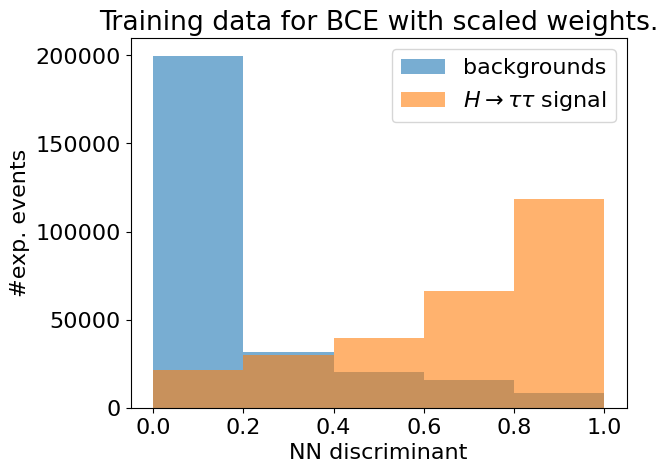

2579/2579 [==============================] - 3s 1ms/step


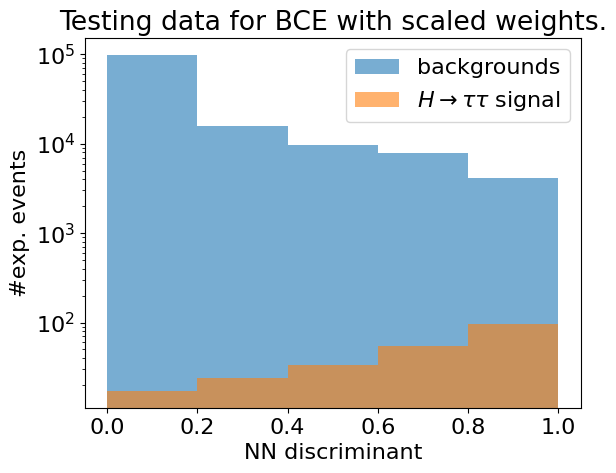

In [541]:
# plot discriminator values for "train" set

# NOTE the weights used to weight the training data are those which the model was trained with. 
# The weights used here to weight the testing data are those given by the data with no scaling 
# - this is to evaluate the model's performance on "raw" data


pred_train = model.predict(X_train)
dfNN = pd.DataFrame()
dfNN["labels"] = y_train
dfNN["predictions"] = pred_train
dfNN["weights"] = final_weights_train
dfNN["mass"] = mass_train

signalVals_train = dfNN[dfNN['labels']== 1] 
backgroundVals_train = dfNN[dfNN['labels']== 0]
plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")
plt.title("Training data for BCE with scaled weights.")
bkgHistNN = plt.hist(backgroundVals_train["predictions"], bins=5, weights=backgroundVals_train["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals_train["predictions"], bins=5, weights=signalVals_train["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

# plot discriminator values for "test" set

pred_test = model.predict(X_test)
dfNN_test = pd.DataFrame()
dfNN_test["labels"] = y_test
dfNN_test["predictions"] = pred_test
dfNN_test["weights"] = weights_test
dfNN_test["mass"] = mass_test

signalVals_test = dfNN_test[dfNN_test['labels']== 1] 
backgroundVals_test = dfNN_test[dfNN_test['labels']== 0] 

plt.figure()
plt.title("Testing data for BCE with scaled weights.")
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN_test = plt.hist(backgroundVals_test["predictions"], bins=5, weights=backgroundVals_test["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN_test = plt.hist(signalVals_test["predictions"], bins=5, weights=signalVals_test["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
plt.yscale('log')
plt.show()



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


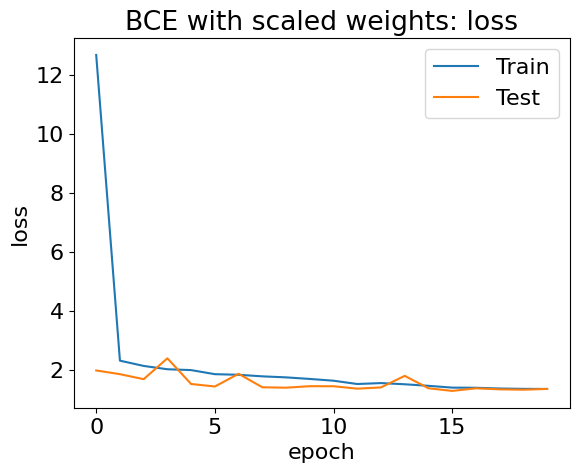

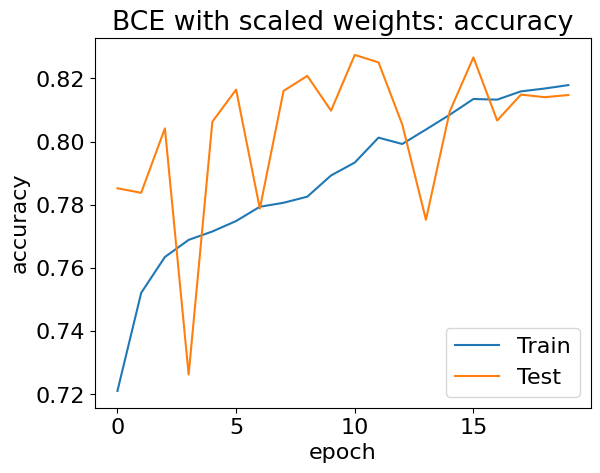

In [511]:
print(history.history.keys())

#Using callbacks.history the loss and accuracy of both the training and testing data as a fucntion of training epoch are plotted

plt.plot(history.history['loss'], label = "Train")
plt.plot(history.history['val_loss'], label = "Test")
plt.title('BCE with scaled weights: loss')
plt.ylabel('loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['accuracy'], label = "Train")
plt.plot(history.history['val_accuracy'], label = "Test")
plt.title('BCE with scaled weights: accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.xlabel('epoch')
plt.show()

# Significance loss functions:

5235/5235 [==============================] - 6s 1ms/step


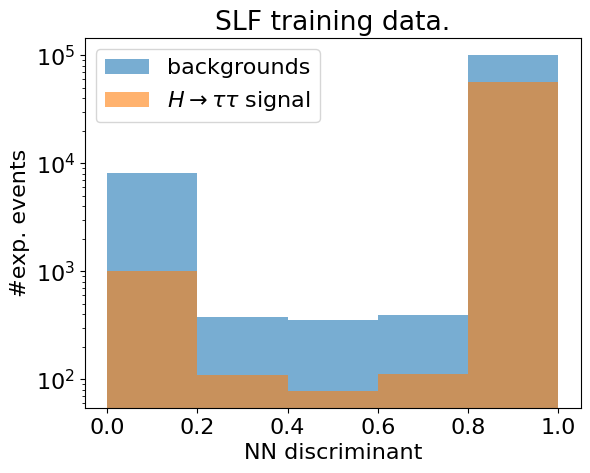

2579/2579 [==============================] - 3s 1ms/step


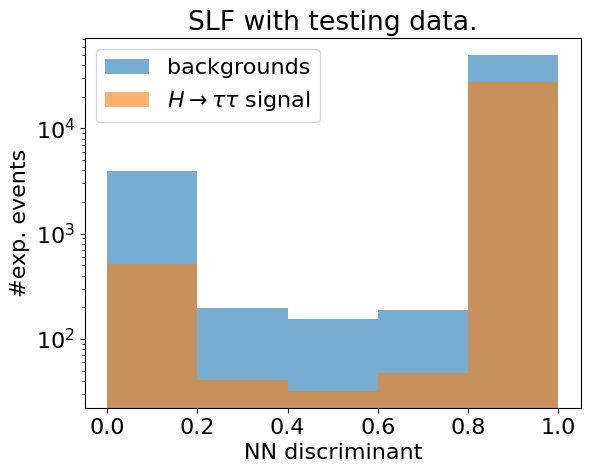

In [537]:
# plot discriminator values for "train" set

#NOTE 
#Weights of 1 are used here as the weights used in training the model are unique to each training batch, 
# therefore the histogram is plotted straight as the output of the model without any further weighting.

pred_train_sig = model_sig.predict(X_train)
dfNN_sig = pd.DataFrame()
dfNN_sig["labels"] = y_train
dfNN_sig["predictions"] = pred_train_sig
dfNN_sig["weights"] = np.ones(len(weights_train))
dfNN_sig["mass"] = mass_train

signalVals_train_sig = dfNN_sig[dfNN_sig['labels']== 1] 
backgroundVals_train_sig = dfNN_sig[dfNN_sig['labels']== 0]

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")
plt.title("SLF training data." )

bkgHistNN_sig = plt.hist(backgroundVals_train_sig["predictions"], bins=5, weights = backgroundVals_train_sig["weights"], label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN_sig = plt.hist(signalVals_train_sig["predictions"], bins=5, weights = signalVals_train_sig["weights"], label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
plt.yscale('log')
plt.show()

# plot discriminator values for "test" set
pred_test_sig = model_sig.predict(X_test)
dfNN_test_sig = pd.DataFrame()
dfNN_test_sig["labels"] = y_test
dfNN_test_sig["predictions"] = pred_test_sig

dfNN_test_sig["weights"] = np.ones(len(weights_test))
dfNN_test_sig["mass"] = mass_test

signalVals_test_sig = dfNN_test_sig[dfNN_test_sig['labels']== 1] 
backgroundVals_test_sig = dfNN_test_sig[dfNN_test_sig['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")
plt.title("SLF with testing data.")
bkgHistNN_test_sig = plt.hist(backgroundVals_test_sig["predictions"], bins=5, weights = backgroundVals_test_sig["weights"], label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN_test_sig = plt.hist(signalVals_test_sig["predictions"], bins=5, weights = signalVals_test_sig["weights"], label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
plt.yscale('log')
plt.show()

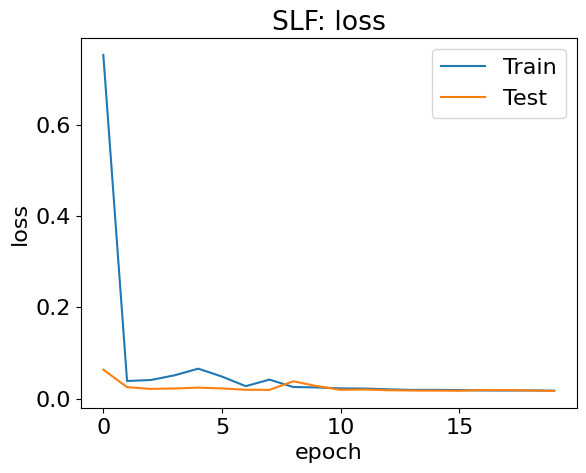

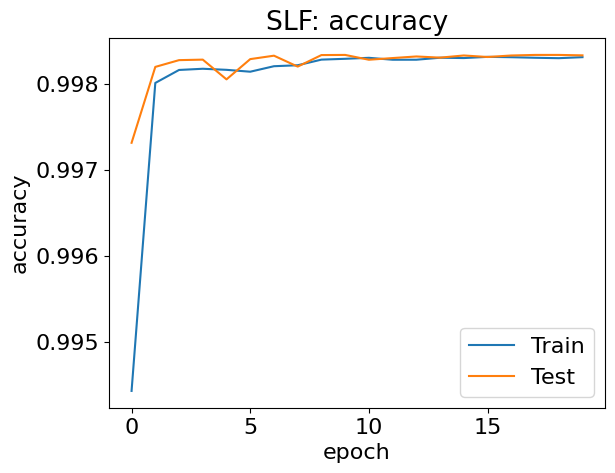

In [526]:
plt.plot(history2.history['loss'], label = "Train")
plt.plot(history2.history['val_loss'], label = "Test")
plt.title('SLF: loss')
plt.ylabel('loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

plt.plot(history2.history['accuracy'], label = "Train")
plt.plot(history2.history['val_accuracy'], label = "Test")
x1,x2,y1,y2 = plt.axis()  
plt.title('SLF: accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# BCE loss function and unscaled weights:

5235/5235 [==============================] - 7s 1ms/step
57613


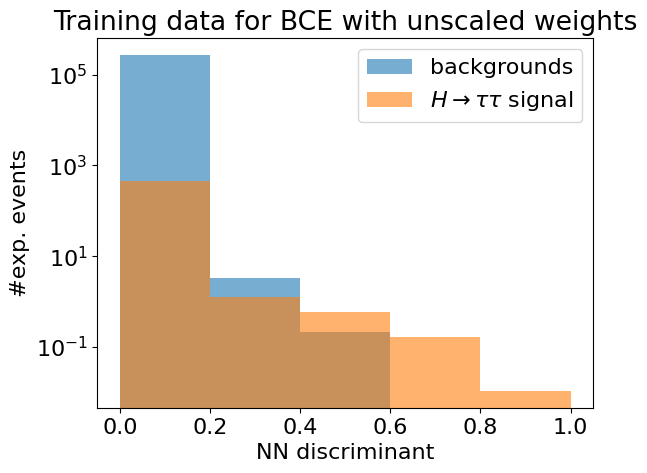

2579/2579 [==============================] - 3s 1ms/step


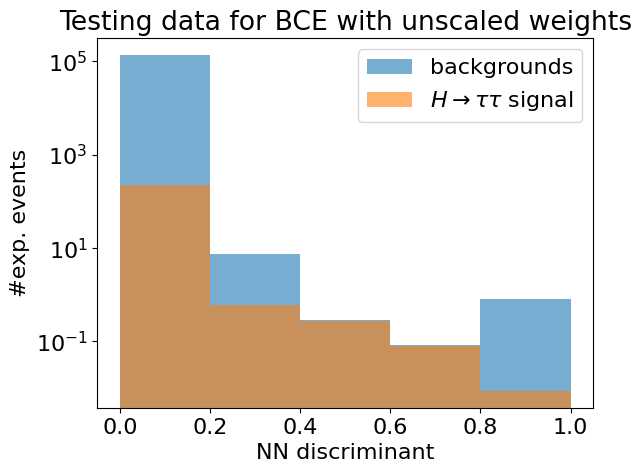

In [527]:
pred_train_un = model_un.predict(X_train)
dfNN_un = pd.DataFrame()
dfNN_un["labels"] = y_train
dfNN_un["predictions"] = pred_train_un
dfNN_un["weights"] = weights_train
dfNN_un["mass"] = mass_train

signalVals_train_un = dfNN_un[dfNN_un['labels']== 1] 
backgroundVals_train_un = dfNN_un[dfNN_un['labels']== 0]

print(len(signalVals_train_un))
plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")
plt.title("Training data for BCE with unscaled weights")
bkgHistNN_un = plt.hist(backgroundVals_train_un["predictions"], bins=5, weights=backgroundVals_train_un["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN_un = plt.hist(signalVals_train_un["predictions"], bins=5, weights=signalVals_train_un["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)
plt.legend()
plt.yscale('log')
plt.show()

# plot discriminator values for "test" set
pred_test_un = model_un.predict(X_test)
dfNN_test_un = pd.DataFrame()
dfNN_test_un["labels"] = y_test
dfNN_test_un["predictions"] = pred_test_un
dfNN_test_un["weights"] = weights_test
dfNN_test_un["mass"] = mass_test

signalVals_test_un = dfNN_test_un[dfNN_test_un['labels']== 1] 
backgroundVals_test_un = dfNN_test_un[dfNN_test_un['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")
plt.title("Testing data for BCE with unscaled weights")
bkgHistNN_test_un = plt.hist(backgroundVals_test_un["predictions"], bins=5, weights=backgroundVals_test_un["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN_test_un = plt.hist(signalVals_test_un["predictions"], bins=5, weights=signalVals_test_un["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)


plt.legend()
plt.yscale('log')
plt.show()

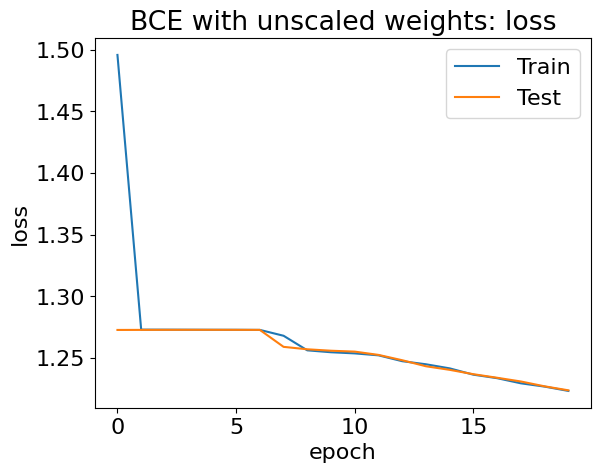

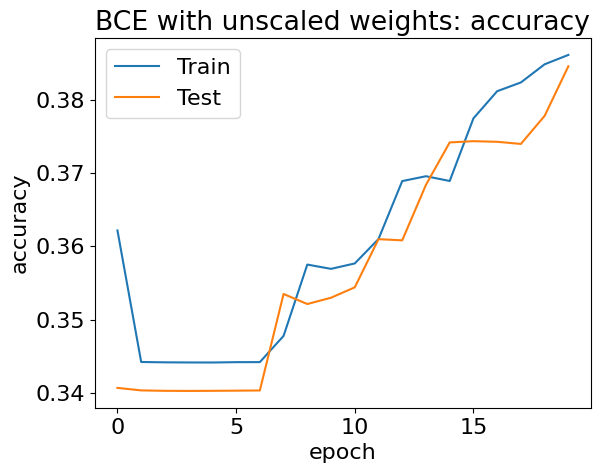

In [528]:
plt.plot(history3.history['loss'], label = "Train")
plt.plot(history3.history['val_loss'], label = "Test")
plt.title('BCE with unscaled weights: loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history3.history['accuracy'], label = "Train")
plt.plot(history3.history['val_accuracy'], label = "Test")
plt.title('BCE with unscaled weights: accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Significance:
Define a function which determines the significance of the signal to background. Can determine the signal significance as a function of mass according to how the network has distributed the events as signal/background.

In [538]:
def getSig(sigHist, bkgHist):

    #extract signifcance vs. discriminant.
    bins = sigHist[1]
    nSig = sigHist[0]
    nBkg = bkgHist[0]

    binCentres = (bins[:-1] + bins[1:]) / 2
    width = bins[1] - bins[0]
    sigmasNN = np.array([])
    sigmasVar = np.array([])

    for x in range(0,len(binCentres)):
        indices = [x, (len(binCentres)-1)] 
        if (nBkg[indices].sum() != 0):
            sigma = (nSig[indices].sum()) / ( np.sqrt(nBkg[indices].sum() + nBkg[indices].sum() ))
        else:
            sigma = 0.001
        sigmasNN = np.append(sigmasNN, sigma)
        
    return binCentres, sigmasNN

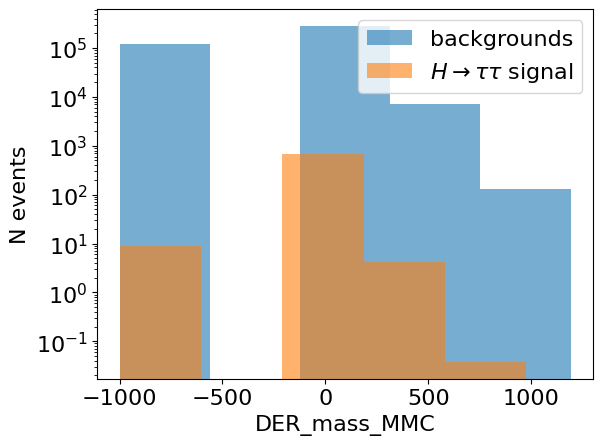

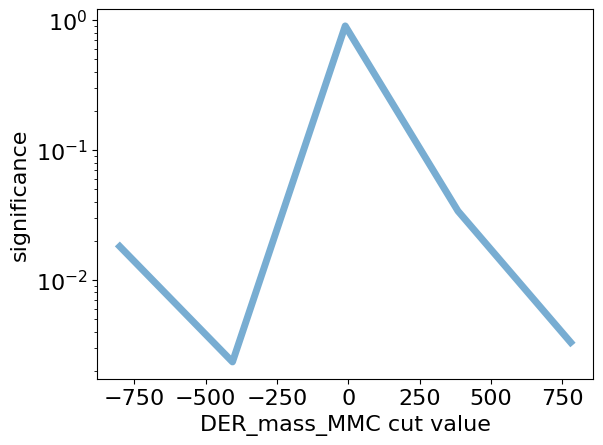

In [539]:
signalVals = df[df['Label']== "s"] 
backgroundVals = df[ df['Label']== "b"]

#True classifications of signal and background:

for var in df.columns:
    if( (var == "DER_mass_MMC") ):   
        plt.yscale('log')
        plt.xlabel(var)
        plt.ylabel("N events")
        bkgHist = plt.hist(backgroundVals[var], bins=5, weights=backgroundVals["Weight"], label="backgrounds", alpha=0.6)
        sigHist = plt.hist(signalVals[var], bins=5, weights=signalVals["Weight"], label=r"$H\rightarrow \tau\tau$ signal", alpha=0.6)
        binCentres, sigmas = getSig(sigHist, bkgHist) 
        plt.legend() 
        #make comparison plot
        fig, ax1 = plt.subplots()
        plt.xlabel(var + " cut value")
        plt.ylabel("significance")
        ax1.plot(binCentres, sigmas, lw=5, alpha=0.6)
        plt.yscale('log')
        plt.show()

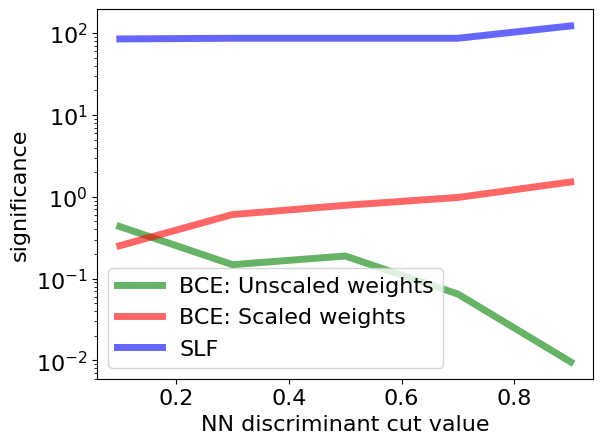

In [542]:
#make comparison plot of signal significance over the discriminant values for all three models
fig, ax1 = plt.subplots()
plt.xlabel("NN discriminant cut value")
plt.ylabel("significance")
plt.yscale('log')

binCentres1, sigmasNN1 = getSig(sigHistNN_test, bkgHistNN_test)
binCentres_sig, sigmasNN_sig = getSig(sigHistNN_test_sig, bkgHistNN_test_sig)
binCentres_un, sigmasNN_un = getSig(sigHistNN_test_un, bkgHistNN_test_un)

ax1.plot(binCentres_un, sigmasNN_un, label="BCE: Unscaled weights", lw=5, alpha=0.6, color = 'g')
ax1.plot(binCentres1, sigmasNN1, label="BCE: Scaled weights", lw=5, alpha=0.6, color='r')
ax1.plot(binCentres_sig, sigmasNN_sig, label="SLF", lw=5, alpha=0.6, color = 'b')
plt.legend()    
plt.show()

Apply a cut value to discriminant classifying signal and background:

# Mass significance plots:

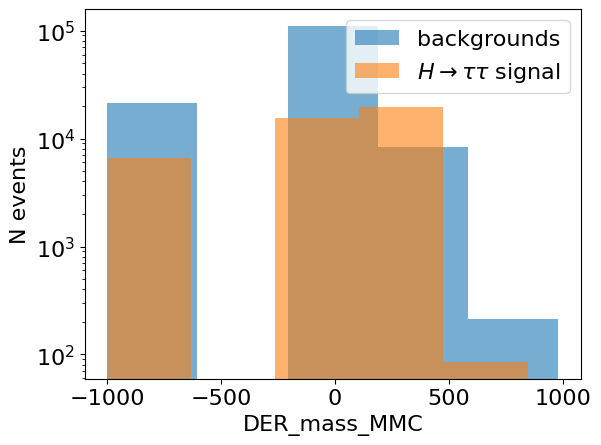

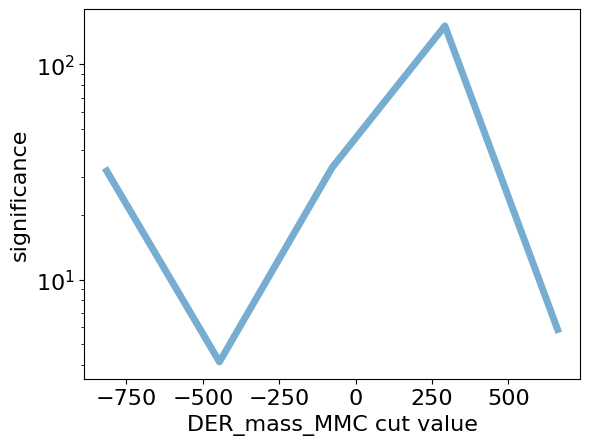

In [532]:
cut = 0.8 

signalVals = dfNN_test[dfNN_test['predictions']>= cut] 
backgroundVals = dfNN_test[dfNN_test['predictions'] < cut] 

#Significance as a function of mass according to the BCE model with scaled weights

for var in df.columns:
    if( (var == "DER_mass_MMC") ):   
        plt.yscale('log')
        plt.xlabel(var)
        plt.ylabel("N events")
        bkgHist = plt.hist(backgroundVals['mass'], bins=5, weights=backgroundVals["weights"], label="backgrounds", alpha=0.6)
        sigHist = plt.hist(signalVals['mass'], bins=5, weights=signalVals["weights"], label=r"$H\rightarrow \tau\tau$ signal", alpha=0.6)
        binCentres, sigmas = getSig(sigHist, bkgHist) 
        plt.legend() 
        #make comparison plot
        fig, ax1 = plt.subplots()
        plt.xlabel(var + " cut value")
        plt.ylabel("significance")
        ax1.plot(binCentres, sigmas, lw=5, alpha=0.6)
        plt.yscale('log')
        plt.show()

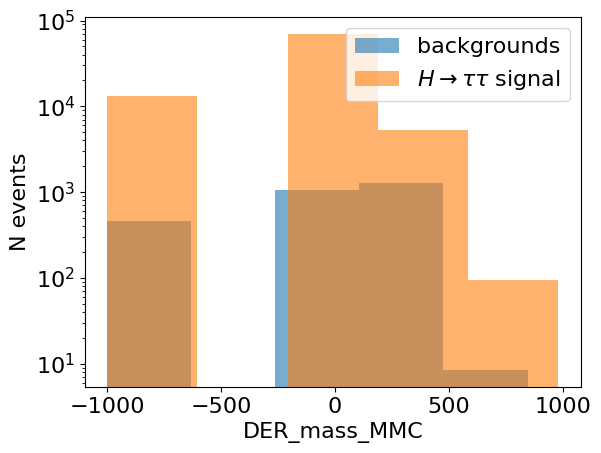

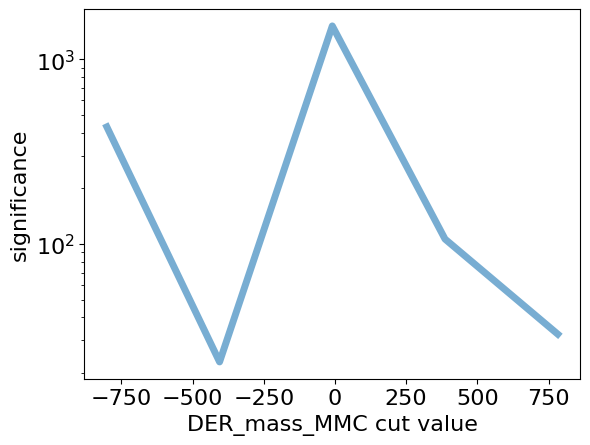

In [533]:
cut = 0.8

signalVals = dfNN_test_sig[dfNN_test_sig['predictions']>= cut] 
backgroundVals = dfNN_test_sig[dfNN_test_sig['predictions'] < cut] 

#Significance as a function of mass according to the SLF model
for var in df.columns:
    if( (var == "DER_mass_MMC") ):   
        plt.yscale('log')
        plt.xlabel(var)
        plt.ylabel("N events")
        bkgHist = plt.hist(backgroundVals['mass'], bins=5, weights=backgroundVals["weights"], label="backgrounds", alpha=0.6)
        sigHist = plt.hist(signalVals['mass'], bins=5, weights=signalVals["weights"], label=r"$H\rightarrow \tau\tau$ signal", alpha=0.6)
        binCentres, sigmas = getSig(sigHist, bkgHist) 
        plt.legend() 
        #make comparison plot
        fig, ax1 = plt.subplots()
        plt.xlabel(var + " cut value")
        plt.ylabel("significance")
        ax1.plot(binCentres, sigmas, lw=5, alpha=0.6)
        plt.yscale('log')
        plt.show()

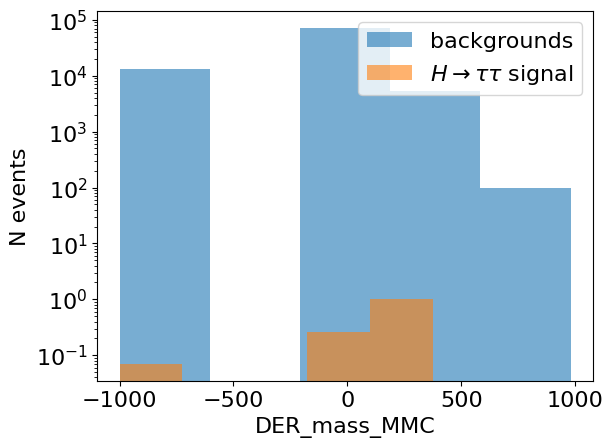

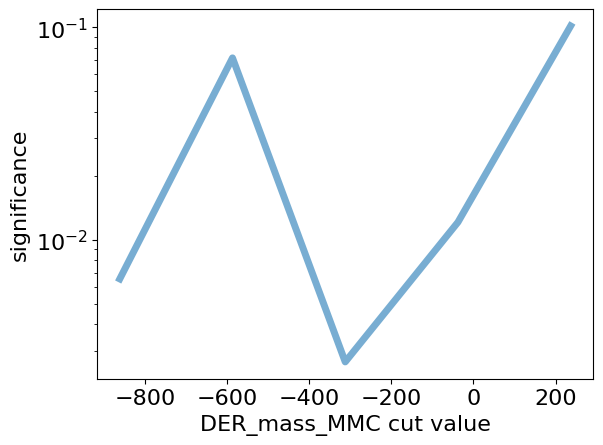

In [534]:
cut = 0.3

signalVals = dfNN_test_un[dfNN_test_un['predictions']>= cut] 
backgroundVals = dfNN_test_un[dfNN_test_un['predictions'] < cut] 

#Significance as a function of mass according to the BCE model with unscaled weights

for var in df.columns:
    if( (var == "DER_mass_MMC") ):   
        plt.yscale('log')
        plt.xlabel(var)
        plt.ylabel("N events")
        bkgHist = plt.hist(backgroundVals['mass'], bins=5, weights=backgroundVals["weights"], label="backgrounds", alpha=0.6)
        sigHist = plt.hist(signalVals['mass'], bins=5, weights=signalVals["weights"], label=r"$H\rightarrow \tau\tau$ signal", alpha=0.6)
        binCentres, sigmas = getSig(sigHist, bkgHist) 
        plt.legend() 
        #make comparison plot
        fig, ax1 = plt.subplots()
        plt.xlabel(var + " cut value")
        plt.ylabel("significance")
        ax1.plot(binCentres, sigmas, lw=5, alpha=0.6)
        plt.yscale('log')
        plt.show()

# Confusion Matrix and F_score:
Further statistics extracted from sklearn functionality

C:\Users\alice\AppData\Local\Temp\ipykernel_30520\4249864044.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


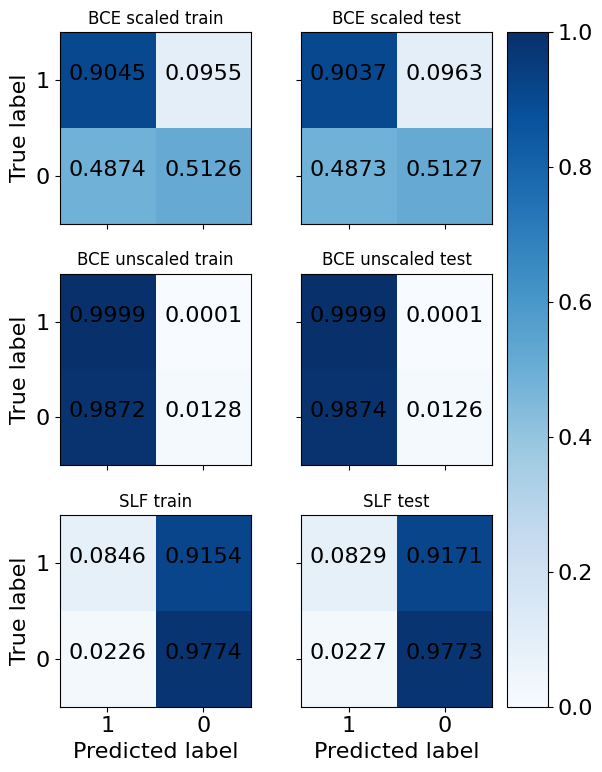

In [535]:
# Confusion matrices:
cut = 0.8
for x in range (len(pred_train)):
    if pred_train[x]>=cut:
        pred_train[x] = 1
    else:
        pred_train[x] = 0

for x in range (len(pred_test)):
    if pred_test[x]>=cut:
        pred_test[x] = 1
    else:
        pred_test[x] = 0

for x in range (len(pred_train_sig)):
    if pred_train_sig[x]>=cut:
        pred_train_sig[x] = 1
    else:
        pred_train_sig[x] = 0

for x in range (len(pred_test_sig)):
    if pred_test_sig[x]>=cut:
        pred_test_sig[x] = 1
    else:
        pred_test_sig[x] = 0

for x in range (len(pred_train_un)):
    if pred_train_un[x]>=0.3:
        pred_train_un[x] = 1
    else:
        pred_train_un[x] = 0

for x in range (len(pred_test_un)):
    if pred_test_un[x]>=0.3:
        pred_test_un[x] = 1
    else:
        pred_test_un[x] = 0

from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_train, pred_train, normalize = 'true' )
ConfusionMatrixDisplay(confusion_matrix=cm)#.plot(ax = axs[0,0])
#plt.title("BCE with scaled weights - training")


cm2 = confusion_matrix(y_test, pred_test, normalize = 'true' )
ConfusionMatrixDisplay(confusion_matrix=cm2)#.plot(ax = axs[0,1])
#plt.title("BCE with scaled weights - test")


cm3 = confusion_matrix(y_train, pred_train_un, normalize = 'true' )
ConfusionMatrixDisplay(confusion_matrix=cm3)#.plot(ax = axs[1,0])
#plt.title("BCE with unscaled weights - training")


cm4 = confusion_matrix(y_test, pred_test_un, normalize = 'true')
ConfusionMatrixDisplay(confusion_matrix=cm4)#.plot(ax = axs[1,1])
#plt.title("BCE with unscaled weights - test")


cm5 =confusion_matrix(y_train, pred_train_sig, normalize = 'true' )
ConfusionMatrixDisplay(confusion_matrix=cm5)#.plot(ax = axs[2,0])
#plt.title("SLF - train")


cm6 = confusion_matrix(y_test, pred_test_sig, normalize = 'true')
ConfusionMatrixDisplay(confusion_matrix=cm6)#.plot(ax = axs[2,1])
#plt.title("SLF - test")

import itertools
from mpl_toolkits.axes_grid1 import ImageGrid


classes = ["1", "0"]

fig = plt.figure(figsize = (14,8))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(3,2),
                 axes_pad=0.5,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
name = ["BCE scaled train", "BCE scaled test", "BCE unscaled train", "BCE unscaled test", "SLF train", "SLF test"]
cms = [cm,cm2,cm3,cm4,cm5,cm6]
for i, ax in enumerate(grid[:6]):
    cm = cms[i]
    im = ax.imshow(cm, vmin=0, vmax=1, cmap=plt.cm.Blues)
    ax.set_title("{}".format(name[i]), fontsize=12)  # ax.___ instead of plt.___
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)  # Warning: different signature for [x|y]ticks in pyplot and OO interface
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], '.4f'),
                 horizontalalignment="center",
                 color="black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.colorbar(im, cax=ax.cax)

plt.show()



In [536]:
# f-score?
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import zero_one_loss
print("The precision is intuitively the ability of the classifier not to label a negative sample as positive.")
print("The recall is intuitively the ability of the classifier to find all the positive samples.")
print("The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.")
print("The support is the number of occurrences of each class in y_true.")
print("(Taken verbatim from sklearn).")
print()

print("BCE Testing data:")
print("Fraction of miscalculations: ", zero_one_loss(y_test, pred_test, normalize=True))
data = precision_recall_fscore_support(y_test, pred_test, average='weighted')
print("Precision: " , data[0])
print("Recall: " , data[1])
print("F_score: " , data[2])
print("Support: " , data[3])
print() 

print("BCE unscaled Testing data:")
print("Fraction of miscalculations: ", zero_one_loss(y_test, pred_test_un, normalize=True))
data = precision_recall_fscore_support(y_test, pred_test_un, average='weighted')
print("Precision: " , data[0])
print("Recall: " , data[1])
print("F_score: " , data[2])
print("Support: " , data[3])
print()  


print("SLF Testing data:")
print("Fraction of miscalculations: ", zero_one_loss(y_test, pred_test_sig, normalize=True))
data = precision_recall_fscore_support(y_test, pred_test_sig, average='weighted')
print("Precision: " , data[0])
print("Recall: " , data[1])
print("F_score: " , data[2])
print("Support: " , data[3])

The precision is intuitively the ability of the classifier not to label a negative sample as positive.
The recall is intuitively the ability of the classifier to find all the positive samples.
The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
The support is the number of occurrences of each class in y_true.

BCE Testing data:
Fraction of miscalculations:  0.2292484848484848
Precision:  0.7656760445275845
Recall:  0.7707515151515152
F_score:  0.7587227547926195
Support:  None

BCE unscaled Testing data:
Fraction of miscalculations:  0.3358424242424243
Precision:  0.7708486832101143
Recall:  0.6641575757575757
F_score:  0.5345495997806629
Support:  None

SLF Testing data:
Fraction of miscalculations:  0.6129696969696969
Precision:  0.6988540321053399
Recall:  0.38703030303030306
F_score:  0.2768540959597125
Support:  None
